In [1]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

In [2]:
rng = Random.default_rng()

# this is just erdos renyi
# n = 1000
# p = 0.9
# eta = 0.
# # graph model 
# meta_g = gen_graph_mun(rng, n, p, eta)
# for e in edges(meta_g)
#     set_prop!(meta_g, e, :angle, 0.0)
# end

# # this is SBM
# c = [50 10;
# 10 50]
# n_blocks = [500 ; 500]
# g =  stochastic_block_model(c, n_blocks)
# meta_g = MetaGraph(g)
# for e in edges(meta_g)
#     set_prop!(meta_g, e, :angle, 0.0)
# end

q = 0.1
c = [50 1 1;
1 50 1;
1 1 50]
n = [200 ; 200; 200]
g =  stochastic_block_model(c, n)
meta_g = MetaGraph(g)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

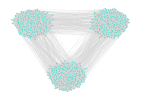

In [3]:
gplot(meta_g)

Forests


USTs


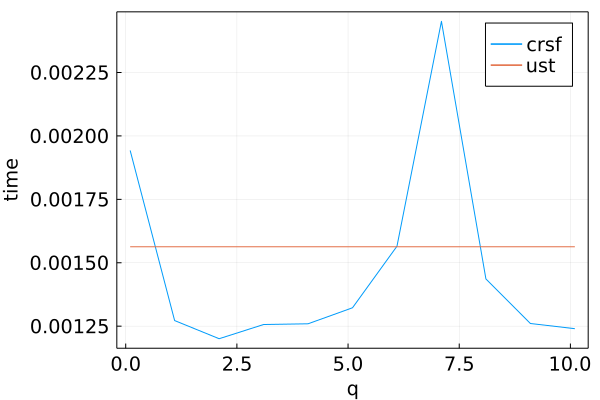

In [7]:

n_rep = 3000

println("Forests")
q_range = 0.1 : 1 : 10.1
nb_q = length(q_range) 

av_time_mtsf = zeros(nb_q,1)
median_time_mtsf = zeros(nb_q,1)
std_time_mtsf = zeros(nb_q,1)
mean_nb_roots = zeros(nb_q,1)
std_nb_roots = zeros(nb_q,1)

for i_q = 0:nb_q
    # skipping the case i_q = 0 (julia warm up) 
    time_mtsf_tp = zeros(n_rep,1)
    nb_roots_tp = zeros(n_rep,1)
    q = 0.1
    if i_q > 0
        q = q_range[i_q]
    end
    for i_rep = 1:n_rep
        vec_mtsf = @timed multi_type_spanning_forest(rng, meta_g, q)
        mtsf = vec_mtsf[1]
        roots = get_prop(mtsf,:roots)
        nb_roots_tp[i_rep] = length(roots)

        #nb_roots
        t_mtsf = vec_mtsf[2]
        time_mtsf_tp[i_rep] = t_mtsf
    end
    if i_q > 0
        mean_nb_roots[i_q] = mean(nb_roots_tp)
        std_nb_roots[i_q] = std(nb_roots_tp)

        av_time_mtsf[i_q] = mean(time_mtsf_tp)
        median_time_mtsf[i_q] = median(time_mtsf_tp)
        std_time_mtsf[i_q] = std(time_mtsf_tp)
    end
end

println("USTs")
# parameters
absorbing_node = true
ust = true

time_ust_tp = zeros(n_rep,1)
for i_rep = 0:n_rep
    # skipping the case i_rep = 0 (julia warm up) 
    q_ust = 0
    vec_ust = @timed multi_type_spanning_forest(rng, meta_g, q_ust;absorbing_node, ust)
    t_ust = vec_ust[2]
    if i_rep > 0
        time_ust_tp[i_rep] = t_ust
    end
end

av_time_ust = mean(time_ust_tp)*ones(size(q_range))
median_time_ust = median(time_ust_tp)*ones(size(q_range))
std_time_ust = std(time_ust_tp)*ones(size(q_range))

plot(q_range, median_time_mtsf, labels = "crsf")
plot!(q_range, median_time_ust, labels = "ust",  
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
legendfont=font(13),
framestyle=:box,)
xlabel!("q")
ylabel!("time")

# plot(q_range, av_time_mtsf,ribbon=std_time_mtsf, labels = "crsf")
# plot!(q_range, av_time_ust,ribbon=std_time_ust, labels = "ust",  
# xtickfont=font(13),
# ytickfont=font(13),
# guidefont=font(13),
# legendfont=font(13),
# framestyle=:box,)
# xlabel!("q")
# ylabel!("time")

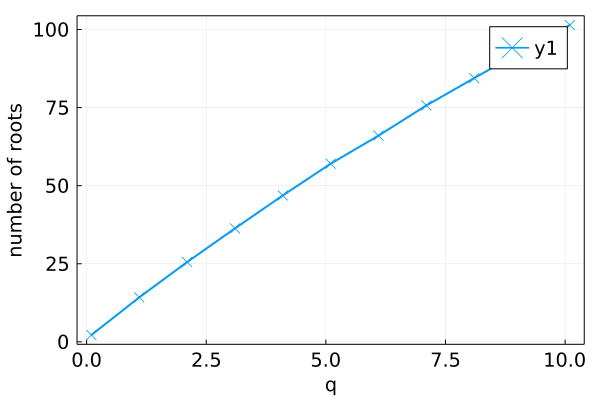

In [6]:
plot(q_range,mean_nb_roots,        
markerstrokecolor=:auto,
markershape=:xcross,
markersize=5,
linewidth=2,
markerstrokewidth=2,
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
legendfont=font(13),
framestyle=:box,
margins=0.1 * 2cm)

xlabel!("q")
ylabel!("number of roots")



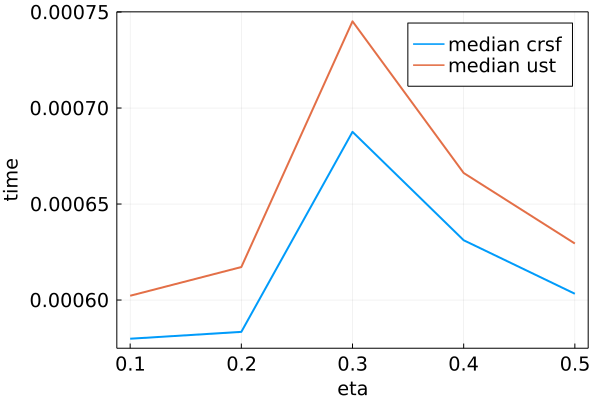

In [24]:
n = 300
p = 0.9

rng = Random.default_rng()

# planted ranking score
planted_score = randperm(rng,n)

# graph model
type = "MUN" 

eta_range = 0.1 : 0.1 : 0.5

nb_eta = length(eta_range) 
n_rep = 100

# parameters
scaling = 50
absorbing_node = true
ust = true
q_ust = 0
q = 0

median_time_crsf = zeros(nb_eta,1)
median_time_ust = zeros(nb_eta,1)

average_time_crsf = zeros(nb_eta,1)
average_time_ust = zeros(nb_eta,1)

mean_nb_cycles = zeros(nb_eta,1)

std_time_crsf = zeros(nb_eta,1)
std_time_ust = zeros(nb_eta,1)

for i_eta = 1:nb_eta
    time_crsf_tp = zeros(n_rep,1)
    time_ust_tp = zeros(n_rep,1)
    nb_cycles_tp = zeros(n_rep,1)

    eta = eta_range[i_eta]

    if type=="MUN"
        meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
        #meta_g = gen_graph_mun_basic(n, p, eta;scaling)
    elseif type=="ERO"
        meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
        #meta_g = gen_graph_ero_basic(n, p, eta;scaling)
    end

    for i_rep = 1:n_rep
        
        vec_ust = @timed multi_type_spanning_forest(rng, meta_g, q_ust;absorbing_node, ust)
        t_ust = vec_ust[2]
        vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
        crsf = vec_crsf[1]
        cycles = get_prop(crsf,:cycle_nodes)
        t_crsf = vec_crsf[2]

        if i_rep > 0 
            time_crsf_tp[i_rep] = t_crsf
            nb_cycles_tp[i_rep] = length(cycles)
            time_ust_tp[i_rep] = t_ust
        end
    end
    mean_nb_cycles[i_eta] = mean(nb_cycles_tp)
    median_time_crsf[i_eta] = median(time_crsf_tp)
    median_time_ust[i_eta] = median(time_ust_tp)

    average_time_crsf[i_eta] = mean(time_crsf_tp)
    average_time_ust[i_eta] = mean(time_ust_tp)

    std_time_crsf[i_eta] = std(time_crsf_tp)
    std_time_ust[i_eta] = std(time_ust_tp)

end

# plot(eta_range, average_time_crsf, labels = "mean crsf",linewidth=2
# )
# plot!(eta_range, average_time_ust, labels = "mean ust",linewidth=2)

plot(eta_range, median_time_crsf, labels = "median crsf",linewidth=2)
plot!(eta_range, median_time_ust, labels = "median ust",  
xtickfont=font(13),
ytickfont=font(13),
guidefont=font(13),
legendfont=font(13),
framestyle=:box,
linewidth=2)
xlabel!("eta")
ylabel!("time")

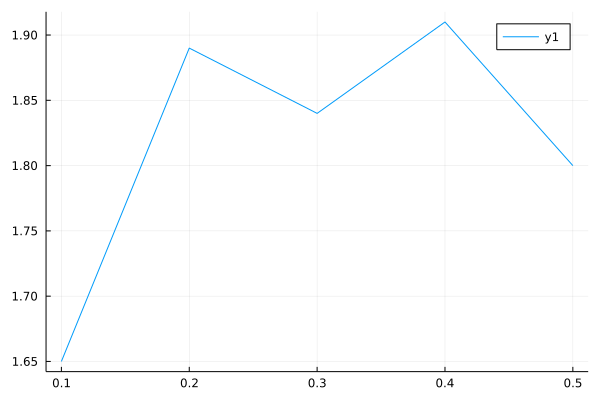

In [25]:
plot(eta_range, mean_nb_cycles)

In [45]:
meta_g = gen_graph_ero(rng, n, p, 0.5;planted_score)
vec_crsf = @timed multi_type_spanning_forest(rng, meta_g, q)
crsf = vec_crsf[1]
cycles = get_prop(crsf,:cycle_nodes)

1-element Vector{Vector{Int64}}:
 [43, 2, 35, 682, 617, 314, 446, 729, 882, 66  …  185, 411, 451, 317, 207, 280, 549, 817, 689, 366]

In [46]:
length(cycles)


1

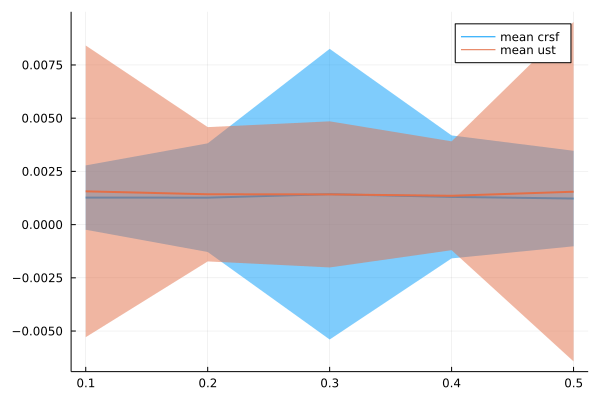

In [18]:
plot(eta_range, average_time_crsf,ribbon=std_time_crsf , labels = "mean crsf",linewidth=2)
plot!(eta_range, average_time_ust,ribbon=std_time_ust, labels = "mean ust",linewidth=2)

In [ ]:
n = 100
p = 0.9
eta = 0.2

rng = Random.default_rng()

# planted ranking score
planted_score = randperm(rng,n)

# graph model
type = "MUN" 

if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end


q_range = 0 : 0.5 : 10

nb_q = length(q_range) 
n_rep = 100

# 
absorbing_node = true
ust = true

av_time_mtsf = zeros(nb_q,1)
av_time_ust = zeros(nb_q,1)

std_time_mtsf = zeros(nb_q,1)
std_time_ust = zeros(nb_q,1)


## real start

for i_q = 1:nb_q
    time_mtsf_tp = zeros(n_rep,1)
    time_ust_tp = zeros(n_rep,1)

    q = q_range[i_q]
    for i_rep = 1:n_rep

        vec_mtsf = @timed multi_type_spanning_forest(rng, meta_g, q;)
        t_mtsf = vec_mtsf[2]

        q_ust = 0
        vec_ust = @timed multi_type_spanning_forest(rng, meta_g, q_ust;absorbing_node, ust)
        t_ust = vec_ust[2]

        time_mtsf_tp[i_rep] = t_mtsf
        time_ust_tp[i_rep] = t_ust

    end
    av_time_mtsf[i_q] = mean(time_mtsf_tp)
    av_time_ust[i_q] = mean(time_ust_tp)

    std_time_mtsf[i_q] = std(time_mtsf_tp)
    std_time_ust[i_q] = std(time_ust_tp)

end

plot(q_range, av_time_crsf,labels = "crsf")
plot!(q_range, av_time_ust, labels = "ust")

In [ ]:
c = [50 10;
10 50]
n = [250 ; 250]
g =  stochastic_block_model(c, n)
meta_g = MetaGraph(g)
for e in edges(meta_g)
    set_prop!(meta_g, e, :angle, 0.0)
end

rng = Random.default_rng()

q_range = 0.1 : 0.2 : 10
nb_q = length(q_range) 
n_rep = 1000

# 
absorbing_node = true
ust = true

av_time_forest = zeros(nb_q,1)
av_time_ust = zeros(nb_q,1)

std_time_forest = zeros(nb_q,1)
std_time_ust = zeros(nb_q,1)

for i_q = 1:nb_q
    time_forest_tp = zeros(n_rep,1)
    time_ust_tp = zeros(n_rep,1)

    q = q_range[i_q]
    for i_rep = 1:n_rep

        vec_forest = @timed multi_type_spanning_forest(rng, meta_g, q;)
        t_forest = vec_forest[2]

        q_ust = 0
        vec_ust = @timed multi_type_spanning_forest(rng, meta_g, q_ust;absorbing_node, ust)
        t_ust = vec_ust[2]

        time_forest_tp[i_rep] = t_forest
        time_ust_tp[i_rep] = t_ust

    end
    av_time_forest[i_q] = mean(time_forest_tp)
    av_time_ust[i_q] = mean(time_ust_tp)

    std_time_forest[i_q] = std(time_forest_tp)
    std_time_ust[i_q] = std(time_ust_tp)

end

plot(q_range, av_time_forest,labels = "forest")
plot!(q_range, av_time_ust, labels = "ust")

ylabel!("time")
xlabel!("q")